In [135]:
import glob
import sys

import corner
import jax
import numpy as np
from flowMC.nfmodel.rqSpline import MaskedCouplingRQSpline
from flowMC.sampler.MALA import MALA
import arviz as az
from flowMC.sampler.Sampler import Sampler
from flowMC.utils.PRNG_keys import initialize_rng_keys
from matplotlib import pyplot as plt
from numpyro import distributions as dist

sys.path.append("gwkokab")

from gwkokab.inference.model_test import *
from gwkokab.utils import get_key

In [136]:
posterior_regex = "ecc_events/event_*.dat"
true_values = np.loadtxt("syn_data/realization_0/configuration.dat")
data_set = [np.loadtxt(event)[:, 0:2] for event in glob.glob(posterior_regex)]
min_size = min([len(event) for event in data_set])
data_set = jnp.asarray([event[:min_size] for event in data_set])

In [137]:
n_chains = 10
n_dim = 4

In [138]:
alpha_prior = dist.Uniform(-5.0, 5.0).sample(get_key(), (n_chains,))
mmin_prior = dist.Uniform(5.0, 30.0).sample(get_key(), (n_chains,))
mmax_prior = dist.Uniform(30.0, 100.0).sample(get_key(), (n_chains,))
rate_prior = dist.LogUniform(10**-1, 10**3).sample(get_key(), (n_chains,))

initial_position = jnp.column_stack([alpha_prior, mmin_prior, mmax_prior, rate_prior])

In [139]:
n_layers = 4
hidden_size = [128, 128]
num_bins = 8

In [140]:
model = MaskedCouplingRQSpline(n_dim, n_layers, hidden_size, num_bins, get_key())

In [141]:
step_size = 1e-1
MALA_Sampler = MALA(log_inhomogeneous_poisson_likelihood, True, {"step_size": 0.1})


n_loop_training = 10
n_loop_production = 10
n_local_steps = 100
n_global_steps = 10
num_epochs = 5

learning_rate = 0.005
momentum = 0.9
batch_size = 5000
max_samples = 5000

rng_key_set = initialize_rng_keys(n_chains, seed=42)

In [142]:
nf_sampler = Sampler(
    n_dim,
    rng_key_set,
    [0.8, 10, 50, 2],
    MALA_Sampler,
    model,
    n_loop_training=n_loop_training,
    n_loop_production=n_loop_production,
    n_local_steps=n_local_steps,
    n_global_steps=n_global_steps,
    n_chains=n_chains,
    n_epochs=num_epochs,
    learning_rate=learning_rate,
    momentum=momentum,
    batch_size=batch_size,
    use_global=True,
)

nf_sampler.sample(initial_position, data=data_set)

out_train = nf_sampler.get_sampler_state(training=True)
print("Logged during tuning:", out_train.keys())

No autotune found, use input sampler_params
Training normalizing flow


Tuning global sampler:   0%|          | 0/10 [00:00<?, ?it/s]

Compiling MALA body


Tuning global sampler: 100%|██████████| 10/10 [01:35<00:00,  9.60s/it]


Starting Production run


Production run: 100%|██████████| 10/10 [00:56<00:00,  5.60s/it]

Logged during tuning: dict_keys(['chains', 'log_prob', 'local_accs', 'global_accs', 'loss_vals'])


In [143]:
chains = np.array(out_train["chains"])
global_accs = np.array(out_train["global_accs"])
local_accs = np.array(out_train["local_accs"])
loss_vals = np.array(out_train["loss_vals"])
nf_samples = np.array(nf_sampler.sample_flow(10000))

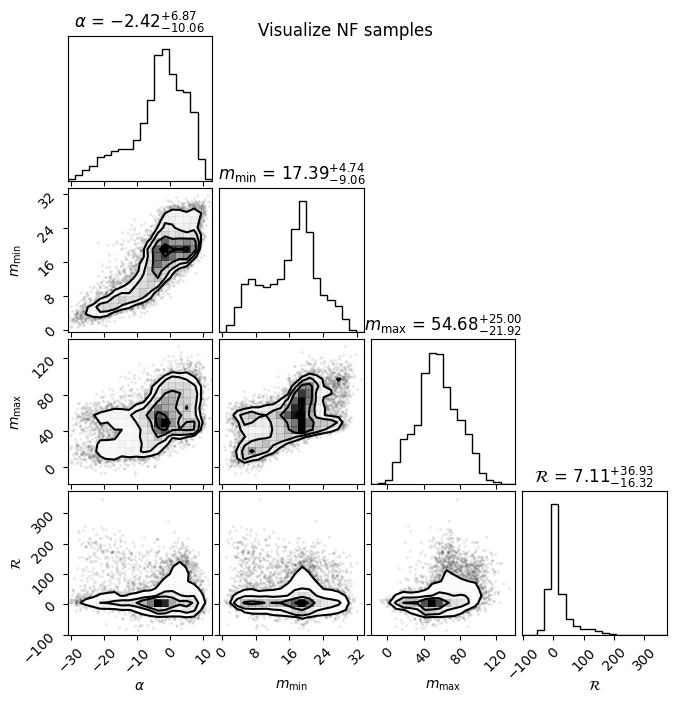

In [144]:
labels = [r"$\alpha$", r"$m_{\text{min}}$", r"$m_{\text{max}}$", r"$\mathcal{R}$"]
# # Plot all chains
# figure = corner.corner(
#     chains.reshape(-1, n_dim),
#     labels=labels,
#     show_titles=True,
# )
# figure.set_size_inches(7, 7)
# figure.suptitle("Visualize samples")
# plt.show(block=False)

# Plot Nf samples
figure = corner.corner(
    nf_samples,
    labels=labels,
    show_titles=True,
)
figure.set_size_inches(7, 7)
figure.suptitle("Visualize NF samples")
plt.show()

Text(0.5, 0, 'Iteration')

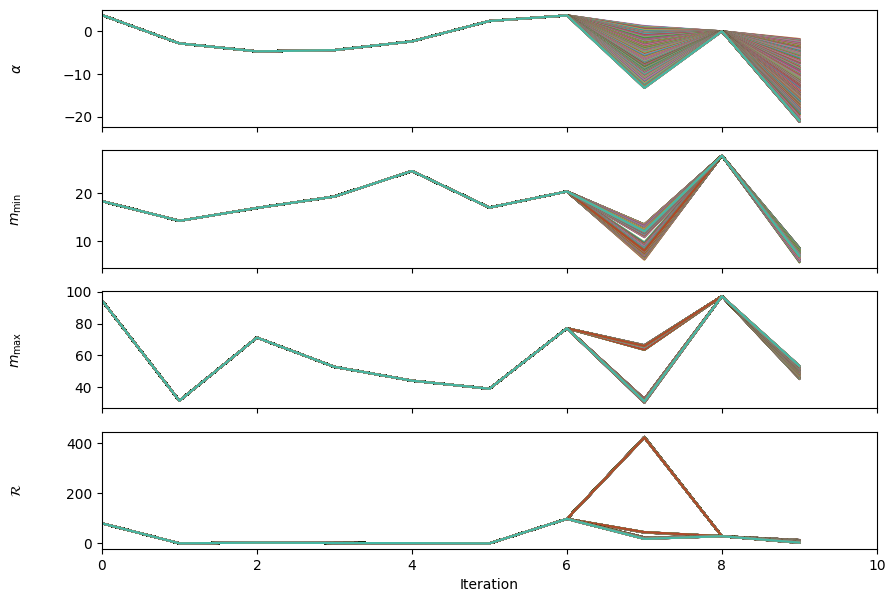

In [145]:
fig, axes = plt.subplots(n_dim, 1, figsize=(10, 7), sharex=True)
for i in range(n_dim):
    axes[i].plot(chains[:, :, i], alpha=0.7)
    axes[i].set_xlim(0, chains.shape[0])
    axes[i].set_ylabel(labels[i])
axes[-1].set_xlabel("Iteration")